In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

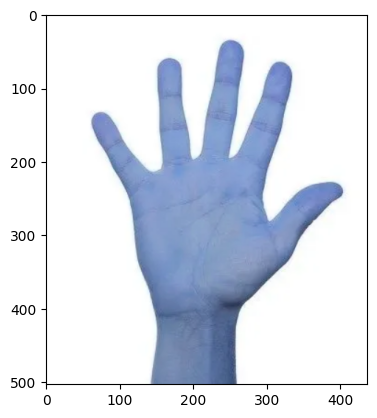

In [2]:
img_path = "../DATA/handddd.png"
img = cv.imread(img_path)
# img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
# cv2.imshow(img)
plt.imshow(img)

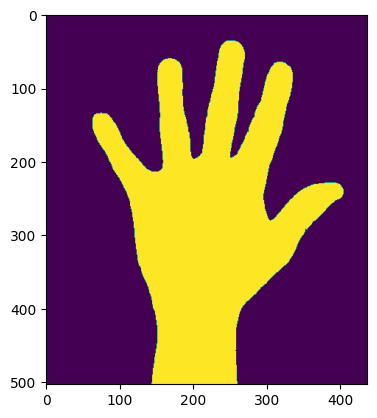

In [3]:
hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
lower = np.array([0, 48, 80], dtype = "uint8")
upper = np.array([20, 255, 255], dtype = "uint8")
skinRegionHSV = cv.inRange(hsvim, lower, upper)
blurred = cv.blur(skinRegionHSV, (2,2))
ret,thresh = cv.threshold(blurred,0,255,cv.THRESH_BINARY)
# cv.imshow("thresh", thresh)
plt.imshow(thresh)

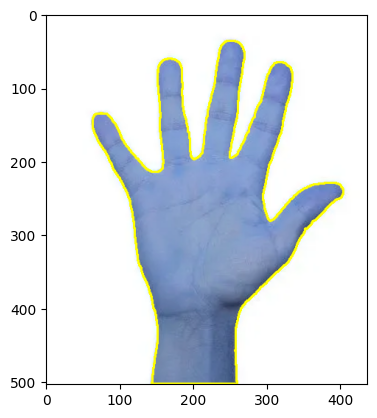

In [4]:
contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
contours = max(contours, key=lambda x: cv.contourArea(x))
cv.drawContours(img, [contours], -1, (255,255,0), 2)
# cv.imshow("contours", img)
plt.imshow(img)

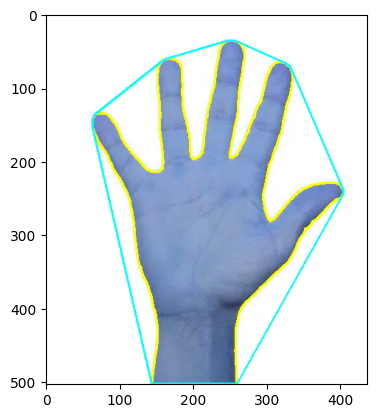

In [5]:
hull = cv.convexHull(contours)
cv.drawContours(img, [hull], -1, (0, 255, 255), 2)
# cv.imshow("hull", img)
plt.imshow(img)

In [6]:
hull = cv.convexHull(contours, returnPoints=False)
defects = cv.convexityDefects(contours, hull)


In [2]:
import numpy as np
import cv2 as cv

def skinmask(img):
    hsvim = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower = np.array([0, 48, 80], dtype = "uint8")
    upper = np.array([20, 255, 255], dtype = "uint8")
    skinRegionHSV = cv.inRange(hsvim, lower, upper)
    blurred = cv.blur(skinRegionHSV, (2,2))
    ret, thresh = cv.threshold(blurred,0,255,cv.THRESH_BINARY)
    return thresh

def getcnthull(mask_img):
    contours, hierarchy = cv.findContours(mask_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours = max(contours, key=lambda x: cv.contourArea(x))
    hull = cv.convexHull(contours)
    return contours, hull

def getdefects(contours):
    hull = cv.convexHull(contours, returnPoints=False)
    defects = cv.convexityDefects(contours, hull)
    return defects

cap = cv.VideoCapture(0) # '0' for webcam
while cap.isOpened():
    _, img = cap.read()
    try:
        mask_img = skinmask(img)
        contours, hull = getcnthull(mask_img)
        cv.drawContours(img, [contours], -1, (255,255,0), 2)
        cv.drawContours(img, [hull], -1, (0, 255, 255), 2)
        defects = getdefects(contours)
        if defects is not None:
            cnt = 0
            for i in range(defects.shape[0]):  # calculate the angle
                s, e, f, d = defects[i][0]
                start = tuple(contours[s][0])
                end = tuple(contours[e][0])
                far = tuple(contours[f][0])
                a = np.sqrt((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2)
                b = np.sqrt((far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2)
                c = np.sqrt((end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2)
                angle = np.arccos((b ** 2 + c ** 2 - a ** 2) / (2 * b * c))  #      cosine theorem
                if angle <= np.pi / 2:  # angle less than 90 degree, treat as fingers
                    cnt += 1
                    cv.circle(img, far, 4, [0, 0, 255], -1)
            if cnt > 0:
                cnt = cnt+1
            cv.putText(img, str(cnt), (0, 50), cv.FONT_HERSHEY_SIMPLEX,1, (255, 0, 0) , 2, cv.LINE_AA)
        cv.imshow("img", img)
    except:
        pass
    if cv.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv.destroyAllWindows()